# Prepare data

In [23]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GroupShuffleSplit

df = pd.read_csv("train.csv", header = 0)

# drop rows with new_whale because it is used to label various unknown flukes yet
df = df[df.Id != 'new_whale']

value_counts = df.Id.value_counts()

# List of targets with one sample to be removed
to_remove = (value_counts == 1).index

# remove targets with one sample
df = df[df['Id'].isin(to_remove)]

# Top 12 labels
top_hitters = value_counts.nlargest(12).index
df = df[df['Id'].isin(top_hitters)]

classes = df.Id.unique()
num_classes = len(classes)

with pd.option_context('display.max_rows', 2, 'display.max_columns', 2):
    print(df)

X = np.array([os.path.join(os.getcwd(), 'train', s) for s in df.Image])
y = np.array(df.Id.values)

# train_inds, test_inds = next(GroupShuffleSplit(n_splits=1, test_size=0.5).split(X, y, groups=y))
# X_train, X_test, y_train, y_test = X[train_inds], X[test_inds], y[train_inds], y[test_inds]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# train_inds, valid_inds = next(GroupShuffleSplit(n_splits=1, test_size=0.2).split(X_train, y_train, groups=y_train))
# X_train, X_valid, y_train, y_valid = X_train[train_inds], X_train[valid_inds], y_train[train_inds], y_train[valid_inds]
# print(np.unique(y_train))
# print(np.unique(y_valid))
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

print('\nThere are %d total classes.' % num_classes)
print('There are %d total images.' % len(X))

print('There are %d training images.' % len(X_train))
print('There are %d validation images.' % len(X_valid))
print('There are %d test images.' % len(X_test))

             Image         Id
1     000466c4.jpg  w_1287fbc
...            ...        ...
9740  fd30f7e6.jpg  w_9b401eb

[278 rows x 2 columns]

There are 12 total classes.
There are 278 total images.
There are 177 training images.
There are 45 validation images.
There are 56 test images.


# Visualize the First 8 Training Images

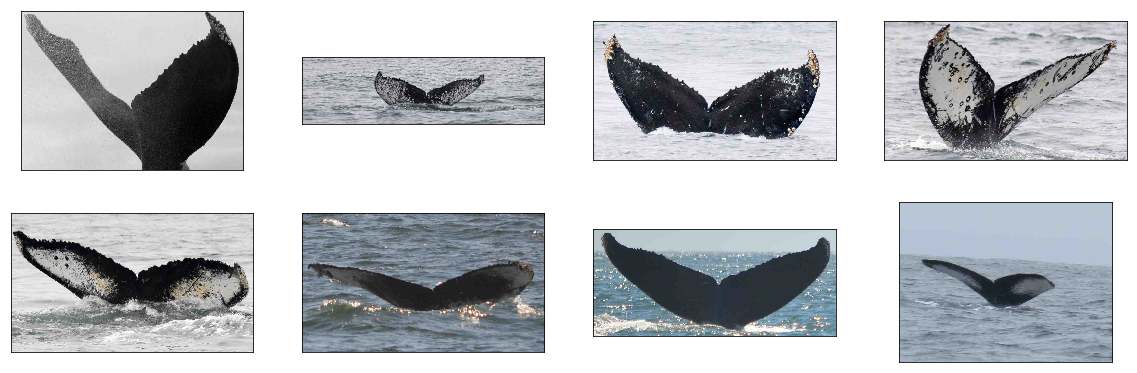

In [24]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(8):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(X_train[i], ax)

# Prepare Dataset for ImageDataGenerator

In [25]:
import shutil
import pathlib
import os

def copy_class_of_files(files, dst, labels):
    for idx, val in enumerate(files):
        dst_dir = os.path.join(dst, labels[idx])
        pathlib.Path(dst_dir).mkdir(parents=True, exist_ok=True)
        shutil.copy(val, dst_dir)
        
shutil.rmtree('./data', ignore_errors=True)
copy_class_of_files(X_train, 'data/train', y_train)
copy_class_of_files(X_valid, 'data/valid', y_valid)
copy_class_of_files(X_test, 'data/test', y_test)

# Load CNN without top layer

In [26]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

# define InceptionResNetV2 model
image_side_size = 299
image_dim = (image_side_size, image_side_size, 3)
base_model = InceptionResNetV2(weights='imagenet', include_top=False,
                          input_tensor=None, input_shape = image_dim, 
                          pooling=None)
for layer in base_model.layers:
    layer.trainable = False
                      
# Train several last layers in base model
# for layer in base_model.layers[-22:]:
#     layer.trainable = True
    
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_610 (Conv2D)             (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_610 (BatchN (None, 149, 149, 32) 96          conv2d_610[0][0]                 
__________________________________________________________________________________________________
activation_610 (Activation)     (None, 149, 149, 32) 0           batch_normalization_610[0][0]    
__________________________________________________________________________________________________
conv2d_611

# Top layer specific to our problem

In [27]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

# Define image generators

In [29]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
target_size = (image_side_size, image_side_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

print("Train generator")
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size,
        shuffle=True)

print("Valid generator")
valid_generator = valid_datagen.flow_from_directory(
        'data/valid',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size)

Train generator
Found 177 images belonging to 12 classes.
Valid generator
Found 45 images belonging to 12 classes.


In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

best_weights_path='whale.flukes.weights.best.hdf5'

# train the model
checkpointer = ModelCheckpoint(filepath=best_weights_path, verbose=1, save_best_only=True)

# Stop the training if the model shows no improvement 
stopper = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=20, verbose=1, mode='auto')

model.fit_generator(generator=train_generator,
                    epochs=1000,
                    steps_per_epoch = int(len(X_train)/batch_size),
                    validation_data=valid_generator, 
                    validation_steps = int(len(X_valid)/batch_size),
                    callbacks=[checkpointer, stopper], verbose=1, workers=8)


Epoch 1/1000
5/5 [==============================] - 85s 17s/step - loss: 3.5879 - acc: 0.0601 - val_loss: 2.4280 - val_acc: 0.1250

Epoch 00001: val_loss improved from inf to 2.42800, saving model to whale.flukes.weights.best.hdf5
Epoch 2/1000
5/5 [==============================] - 78s 16s/step - loss: 2.4821 - acc: 0.1318 - val_loss: 2.4060 - val_acc: 0.0938

Epoch 00002: val_loss improved from 2.42800 to 2.40599, saving model to whale.flukes.weights.best.hdf5
Epoch 3/1000
5/5 [==============================] - 76s 15s/step - loss: 2.4154 - acc: 0.1628 - val_loss: 2.5019 - val_acc: 0.0312

Epoch 00003: val_loss did not improve
Epoch 4/1000
5/5 [==============================] - 82s 16s/step - loss: 2.3763 - acc: 0.1438 - val_loss: 2.5907 - val_acc: 0.0312

Epoch 00004: val_loss did not improve
Epoch 5/1000
5/5 [==============================] - 70s 14s/step - loss: 2.3241 - acc: 0.1963 - val_loss: 2.3660 - val_acc: 0.3125

Epoch 00005: val_loss improved from 2.40599 to 2.36600, saving


Epoch 00043: val_loss did not improve
Epoch 44/1000
5/5 [==============================] - 83s 17s/step - loss: 0.8268 - acc: 0.6562 - val_loss: 1.7072 - val_acc: 0.4688

Epoch 00044: val_loss did not improve
Epoch 45/1000
5/5 [==============================] - 77s 15s/step - loss: 0.8222 - acc: 0.7435 - val_loss: 1.8599 - val_acc: 0.3438

Epoch 00045: val_loss did not improve
Epoch 46/1000
5/5 [==============================] - 76s 15s/step - loss: 0.8181 - acc: 0.7255 - val_loss: 2.1337 - val_acc: 0.3438

Epoch 00046: val_loss did not improve
Epoch 47/1000
5/5 [==============================] - 76s 15s/step - loss: 0.8131 - acc: 0.7481 - val_loss: 1.7950 - val_acc: 0.4062

Epoch 00047: val_loss did not improve
Epoch 48/1000
5/5 [==============================] - 76s 15s/step - loss: 0.8962 - acc: 0.6909 - val_loss: 2.7262 - val_acc: 0.1562

Epoch 00048: val_loss did not improve
Epoch 49/1000
5/5 [==============================] - 75s 15s/step - loss: 0.8393 - acc: 0.6944 - val_loss:

# Load the Model with the Best Validation Loss

In [31]:
model.load_weights(best_weights_path)

# Calculate Classification Accuracy on Test Set

In [32]:
workers = 8

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    "data/test",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', shuffle=False)

score = model.evaluate_generator(
    generator=test_generator, 
    steps=len(X_test)/batch_size,
    workers=workers)

print("Loss: ", score[0], "Accuracy: ", score[1])

scores = model.predict_generator(
    generator=test_generator, 
    steps=len(X_test)/batch_size,
    workers=workers)

Found 56 images belonging to 12 classes.
Loss:  1.50494725364 Accuracy:  0.517857147115


# Print confusion matrix

Confusion matrix, without normalization
Normalized confusion matrix


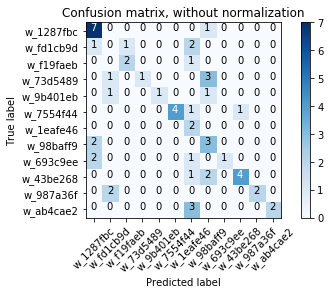

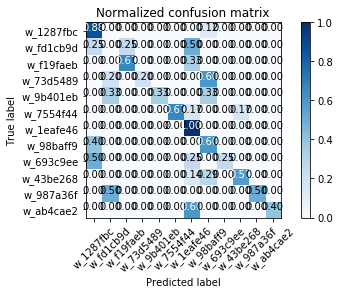

In [33]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(test_generator.classes, list(map(lambda x: np.argmax(x), scores)))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

# Write classification result

In [34]:
import csv
import ntpath

with open('predictions.csv', 'w') as csvfile:
    fieldnames = ['Image', 'Id']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    
    for idx, file_name in enumerate(X_test):
        probs = scores[idx]
        _, sorted_classes = zip(*sorted(zip(probs, classes), reverse=True))
        writer.writerow(dict(zip(fieldnames, [ntpath.basename(file_name), ' '.join(sorted_classes[:3])])))